# ExtraCreditProject_ml6506
# Prediction of Emergency Response Time in NYC

In [546]:
from __future__ import print_function, division
import geopandas as gp
import shapely
import pandas as pd
import numpy  as np
import urllib
import os
from fiona.crs import from_epsg

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve

from sklearn import ensemble
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble  import RandomForestClassifier as rfc

import pylab as pl
pl.rcParams["font.size"] = 18
pl.rcParams["figure.figsize"] = (10,10)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Reading in Data
##### data sourced from (https://data.cityofnewyork.us/Public-Safety/Emergency-Response-Incidents/pasr-j7fb) 

In [547]:
!curl -O https://data.cityofnewyork.us/api/views/pasr-j7fb/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  904k    0  904k    0     0  1803k      0 --:--:-- --:--:-- --:--:-- 1802k


In [548]:
!mv rows.csv\?accessType\=DOWNLOAD $PUIDATA/NYEmerResp.csv

In [549]:
NYEmerResp = pd.read_csv(os.getenv("PUIDATA") + "/NYEmerResp.csv")

In [550]:
NYEmerResp.head()

,Incident Type,Location,Borough,Creation Date,Closed Date,Latitude,Longitude
0,Utility-Water Main,136-17 72 Avenue,Queens,01/16/2017 01:13:38 PM,NaN,40.714004,-73.829989
1,Structural-Sidewalk Collapse,927 Broadway,Manhattan,10/29/2016 12:13:31 PM,NaN,40.714422,-74.006076
2,Utility-Other,NaN,Manhattan,11/22/2016 08:53:17 AM,NaN,NaN,NaN
3,Administration-Other,Seagirt Blvd & Beach 9 Street,Queens,11/14/2016 03:53:54 PM,NaN,40.714004,-73.829989
4,Law Enforcement-Other,NaN,Brooklyn,10/29/2016 05:35:28 PM,NaN,NaN,NaN


In [551]:
NYEmerResp.dropna(inplace=True)

In [552]:
NYEmerResp.shape

(4999, 7)

# Data Viz

In [553]:
NYEmerResp['lonlat'] = list(zip(NYEmerResp.Longitude, NYEmerResp.Latitude))

#### I found there is a error value in Longitude by plotting them in geopandas, so I correct it down below

In [554]:
res = NYEmerResp.sort_values('Longitude', ascending = False)
res.head()

,Incident Type,Location,Borough,Creation Date,Closed Date,Latitude,Longitude,lonlat
1961,Utility-Power Outage,Vermont Avenue & Hyland Blvd,Staten Island,06/12/2015 07:36:57 AM,06/12/2015 10:28:17 AM,40.614000,74.071800,"(74.0718, 40.614)"
2131,Administration-OEM Involved MVA,Searing Avenue & Roslyn Road,Nassau,04/18/2013 09:33:22 PM,04/18/2013 11:10:39 PM,40.767784,-73.679726,"(-73.6797257815, 40.7677841535)"
5603,Utility-Power Outage,271-11 76 Ave,Queens,09/19/2011 06:39:59 PM,09/20/2011 06:47:58 AM,40.754148,-73.705918,"(-73.7059176995, 40.7541482608)"
6866,Utility-Water Service Line,271-11 76th Avenue,Queens,09/17/2013 07:10:00 AM,11/05/2013 07:22:29 PM,40.754094,-73.705976,"(-73.7059756917, 40.7540935136)"
3783,HazMat-High Carbon Monoxide,260-08 86th Avenue,Queens,04/10/2015 03:37:38 PM,04/10/2015 09:09:36 PM,40.733521,-73.706705,"(-73.7067051375, 40.7335206112)"


In [555]:
NYEmerResp.drop([1961], inplace = True);

In [556]:
NYEmerResp_gp = NYEmerResp

In [557]:
NYEmerResp_gp['geometry'] = NYEmerResp_gp[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
NYEmerResp_gp = gp.GeoDataFrame(NYEmerResp_gp)

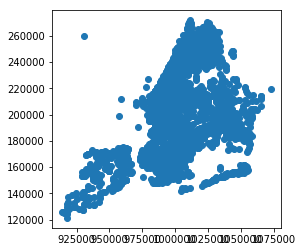

In [558]:
NYEmerResp_gp.crs= from_epsg(4326)
NYEmerResp_gp.to_crs(epsg=2263, inplace = True)
NYEmerResp_gp.plot()

### Figure1. Cases distribution in NYC

In [561]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7f28d947bda0>)

In [562]:
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/ml6506/PUIdata/geo_export_6b74762c-51bf-41c3-b5bc-58c0cf3260d4.dbf  
  inflating: /nfshome/ml6506/PUIdata/geo_export_6b74762c-51bf-41c3-b5bc-58c0cf3260d4.shp  
  inflating: /nfshome/ml6506/PUIdata/geo_export_6b74762c-51bf-41c3-b5bc-58c0cf3260d4.shx  
  inflating: /nfshome/ml6506/PUIdata/geo_export_6b74762c-51bf-41c3-b5bc-58c0cf3260d4.prj  


In [563]:
boro = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_f4a61e65-eb61-4276-b782-53f52b3802fd.shp")

In [564]:
boro.crs= from_epsg(4326)
boro.to_crs(epsg=2263, inplace = True)

(903669.0917996905, 1083455.3175172159, 111191.91223960771, 281940.087673662)

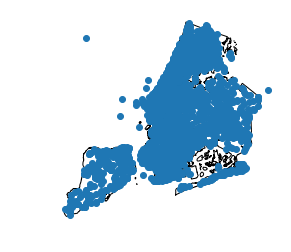

In [565]:
ax = boro.plot(facecolor="w", edgecolor="k")
NYEmerResp_gp.plot(ax=ax)
ax.axis('off')

### Figure2. Cases distribution in NYC with boundary

# Clean up Data

In [566]:
NYEmerResp.drop(['Location'], axis = 1, inplace = True)
NYEmerResp.head()

,Incident Type,Borough,Creation Date,Closed Date,Latitude,Longitude,lonlat,geometry
11,Fire-3rd Alarm,new york,11/30/2016 12:25:38 AM,11/30/2016 04:22:22 AM,40.667490,-73.994286,"(-73.9942860004, 40.6674897029)",POINT (985835.155156477 182460.9466399394)
52,Rescue-Technical,Queens,11/22/2016 12:24:02 PM,11/22/2016 06:27:30 PM,40.714004,-73.829989,"(-73.8299893315, 40.714003641)",POINT (1031380.767334146 199453.0226717225)
63,Fire-1st Alarm,Far Rockaway,08/04/2017 02:08:12 PM,08/04/2017 02:49:18 PM,40.595224,-73.781105,"(-73.7811048299, 40.5952240909)",POINT (1045040.759909836 156208.5491830893)
64,Law Enforcement-Suspicious Package,Brooklyn,08/04/2017 05:35:14 PM,08/04/2017 06:08:54 PM,40.614392,-74.031187,"(-74.0311868027, 40.6143922637)",POINT (975591.3935548743 163117.5957336107)
66,Utility-Steam Main,Manhattan,08/04/2017 08:07:43 AM,08/04/2017 11:43:58 PM,40.754862,-73.968543,"(-73.968543, 40.754862)",POINT (992965.2449583234 214294.8353438493)


### Borough Clean

In [567]:
NYEmerResp.Borough.unique()

array(['new york', 'Queens', 'Far Rockaway', 'Brooklyn', 'Manhattan',
       'Bronx', 'manhattan', 'bronx', 'New York', 'Jamaice', 'queens',
       'Staten Island', 'Long Island City', 'Staten ISland', 'New Yotk',
       'staten island', 'Bronx (NYCHA)', 'Manhaatan', 'BRonx',
       'New York/Manhattan', 'Mnahattan', 'QUEENS', 'Nassau', 'Jamaica',
       'Manahttan', 'Manhatten', 'Manhatan', 'quenns',
       'Brooklyn (NYCHA-Brevoort)', 'Staten Island (Midland Beach Area)',
       'nyc', 'Hollis', 'MANHATTAN', 'Manhttan',
       'Manhattan (Waldorf Astoria)', 'Mahattan', 'Staten island',
       'Manhattan (Pier 92)', 'staten Island', 'BrONX', 'NewYork',
       'Manhhattan', 'Mamhattan'], dtype=object)

In [568]:
NYEmerResp.Borough.replace(['Manhattah', 'manhattan', 
                            'Manhaatan', 'New York/Manhattan',
                            'Mnahattan','Manhatan', 'Manhttan', 
                            'Manhatten', 'Manahttan', 'Manhhattan', 
                            'Mamhattan', 'MANHATTAN', 'Manhattan (Pier 92)', 
                            'Manhattan (Waldorf Astoria)', 'Mahattan'], 'Manhattan', inplace = True)
NYEmerResp.Borough.replace(['queens', 'QUEENS', 'quenns'], 'Queens', inplace = True)
NYEmerResp.Borough.replace(['Brooklyn (NYCHA-Brevoort)'], 'Brooklyn', inplace = True)
NYEmerResp.Borough.replace(['bronx', 'Bronx (NYCHA)', 'BRonx', 'BrONX'], 'Bronx', inplace = True)
NYEmerResp.Borough.replace(['Jamaice'], 'Jamaica', inplace = True)
NYEmerResp.Borough.replace(['Staten ISland', 'staten island', 'staten Island', 
                            'Staten island', 'Staten Island (Midland Beach Area)',
                            'Staten Island (Midland Beach Area)', 'SI', 'Richmond/Staten Island'], 'Staten Island',  inplace = True)
NYEmerResp.Borough.replace(['new york', 'New Yotk', 'nyc', 'NewYork', 'new York'], 'New York', inplace = True)


NYEmerResp.Borough.unique()

array(['New York', 'Queens', 'Far Rockaway', 'Brooklyn', 'Manhattan',
       'Bronx', 'Jamaica', 'Staten Island', 'Long Island City', 'Nassau',
       'Hollis'], dtype=object)

### Incident Type Clean

In [569]:
NYEmerResp.head()
print(NYEmerResp['Incident Type'][:500].unique())

['Fire-3rd Alarm' 'Rescue-Technical' 'Fire-1st Alarm'
 'Law Enforcement-Suspicious Package' 'Utility-Steam Main'
 'Structural-Street Collapse' 'Utility-Gas Low Pressure' 'Utility-Manhole'
 'Transportation-Other' 'Transportation-Train Subway' 'Structural-Other'
 'Utility-Other' 'Structural-Construction Accident'
 'Structural-Partial Collapse' 'Utility-Power Outage' 'Rescue-High Angle'
 'Law Enforcement-Other' 'Utility-Gas High Pressure'
 'Fire-10-76 (Commercial High Rise Fire)' 'Fire-2nd Alarm' 'Fire-5th Alarm'
 'Utility-Water Main' 'Fire-School' 'Rescue-Confined Space'
 'Structural-Life Safety Violations' 'Structural-Scaffold'
 'Structural-Evacuation' 'Marine-Passenger Liner'
 'Law Enforcement-Explosion' 'Fire-Nursing Home' 'Structural-Collapse'
 'Structural-Sidewalk Collapse' 'Structural-Crane' 'Fire-Other'
 'Structural-Demolition' 'Aviation-Other' 'Rescue-Other' 'HazMat-Other'
 'Administration-Planned Event' 'Fire-10-77 (Residential High Rise Fire)'
 'Medical-EMS MCI (Multiple Casual

In [570]:
NYEmerResp['Incident Type'] = NYEmerResp['Incident Type'].str.split('-', expand=True)[0]
print(NYEmerResp['Incident Type'].unique())

['Fire' 'Rescue' 'Law Enforcement' 'Utility' 'Structural' 'Transportation'
 'Marine' 'Aviation' 'HazMat' 'Administration' 'Medical' 'LawEnforcement'
 'Weather' 'Other']


In [571]:
NYEmerResp.head()

,Incident Type,Borough,Creation Date,Closed Date,Latitude,Longitude,lonlat,geometry
11,Fire,New York,11/30/2016 12:25:38 AM,11/30/2016 04:22:22 AM,40.667490,-73.994286,"(-73.9942860004, 40.6674897029)",POINT (985835.155156477 182460.9466399394)
52,Rescue,Queens,11/22/2016 12:24:02 PM,11/22/2016 06:27:30 PM,40.714004,-73.829989,"(-73.8299893315, 40.714003641)",POINT (1031380.767334146 199453.0226717225)
63,Fire,Far Rockaway,08/04/2017 02:08:12 PM,08/04/2017 02:49:18 PM,40.595224,-73.781105,"(-73.7811048299, 40.5952240909)",POINT (1045040.759909836 156208.5491830893)
64,Law Enforcement,Brooklyn,08/04/2017 05:35:14 PM,08/04/2017 06:08:54 PM,40.614392,-74.031187,"(-74.0311868027, 40.6143922637)",POINT (975591.3935548743 163117.5957336107)
66,Utility,Manhattan,08/04/2017 08:07:43 AM,08/04/2017 11:43:58 PM,40.754862,-73.968543,"(-73.968543, 40.754862)",POINT (992965.2449583234 214294.8353438493)


In [572]:
NYEmerResp["Borough"] = pd.Categorical(NYEmerResp.Borough).codes
pd.Categorical(NYEmerResp.Borough)
NYEmerResp["Incident Type"] = pd.Categorical(NYEmerResp['Incident Type']).codes
pd.Categorical(NYEmerResp['Incident Type'])

[2, 9, 2, 4, 12, ..., 2, 4, 4, 9, 4]
Length: 4998
Categories (14, int64): [0, 1, 2, 3, ..., 10, 11, 12, 13]

In [573]:
# NYEmerResp.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)
NYEmerResp.dropna(inplace=True)
NYEmerResp = NYEmerResp.reset_index().drop('index',axis = 1)
NYEmerResp.columns

Index(['Incident Type', 'Borough', 'Creation Date', 'Closed Date', 'Latitude',
       'Longitude', 'lonlat', 'geometry'],
      dtype='object')

###  Time Length

In [574]:
end_date = pd.to_datetime(NYEmerResp['Closed Date'])
start_date = pd.to_datetime(NYEmerResp['Creation Date'])
# print(lambda x: end_date[x] - start_date[x] )
NYEmerResp['ResponseTime'] = list(map(lambda x: (end_date[x] - start_date[x]), range(NYEmerResp.shape[0])))

In [575]:
def classifyHours(timeDelta):
    hours = timeDelta.days*24 + timeDelta.seconds/60./60
    # 1 hour
    if hours <= 1: 
        return 0
    # 1 day
    elif hours <= 24:
        return 1
    # 1 week
    elif hours <= 24*7:
        return 2
    # longer
    else:
        return 3

In [576]:
timeLengthClassList = []
for i in range(NYEmerResp.shape[0]):
    timeLengthClassList.append(classifyHours(NYEmerResp['ResponseTime'][i]))

In [577]:
NYEmerResp['timeLengthClass'] = timeLengthClassList
NYEmerResp.head()

,Incident Type,Borough,Creation Date,Closed Date,Latitude,Longitude,lonlat,geometry,ResponseTime,timeLengthClass
0,2,8,11/30/2016 12:25:38 AM,11/30/2016 04:22:22 AM,40.667490,-73.994286,"(-73.9942860004, 40.6674897029)",POINT (985835.155156477 182460.9466399394),03:56:44,1
1,9,9,11/22/2016 12:24:02 PM,11/22/2016 06:27:30 PM,40.714004,-73.829989,"(-73.8299893315, 40.714003641)",POINT (1031380.767334146 199453.0226717225),06:03:28,1
2,2,2,08/04/2017 02:08:12 PM,08/04/2017 02:49:18 PM,40.595224,-73.781105,"(-73.7811048299, 40.5952240909)",POINT (1045040.759909836 156208.5491830893),00:41:06,0
3,4,1,08/04/2017 05:35:14 PM,08/04/2017 06:08:54 PM,40.614392,-74.031187,"(-74.0311868027, 40.6143922637)",POINT (975591.3935548743 163117.5957336107),00:33:40,0
4,12,6,08/04/2017 08:07:43 AM,08/04/2017 11:43:58 PM,40.754862,-73.968543,"(-73.968543, 40.754862)",POINT (992965.2449583234 214294.8353438493),15:36:15,1


In [578]:
NYEmerResp.dropna()
NYEmerResp.shape
# NYEmerResp.drop(['Creation Date','Closed Date'], axis = 1, inplace = True)

(4998, 10)

{0, 1, 2, 3}

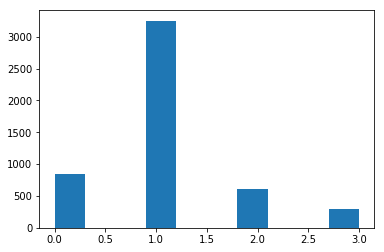

In [579]:
import matplotlib.pyplot as plt
plt.hist(NYEmerResp['timeLengthClass'])
set(NYEmerResp['timeLengthClass'])

### Figure3. Time Length Classification. From this figure, we could find that the most cases can be solves with 1 day( return 0 and 1 )

In [372]:
NYEmerResp['Creation Date'] = pd.to_datetime(NYEmerResp['Creation Date'])


In [582]:
# NYEmerResp creation time feature
CreationMonthList = []
CreationYearList = []
for i in range(NYEmerResp.shape[0]):
    CreationMonthList.append(NYEmerResp['Creation Date'][i].month)
    CreationYearList.append(NYEmerResp['Creation Date'][i].year)
NYEmerResp['CreationMonth'] = CreationMonthList
NYEmerResp['CreationYear'] = CreationYearList
trainInput = NYEmerResp[['Incident Type','CreationYear','CreationMonth','Borough','Latitude','Longitude']]
# trainInput['Incident Type'] = NYEmerResp['Incident Type']
trainOutput = NYEmerResp[['timeLengthClass']]
trainInput.head()

,Incident Type,CreationYear,CreationMonth,Borough,Latitude,Longitude
0,2,2016,11,8,40.667490,-73.994286
1,9,2016,11,9,40.714004,-73.829989
2,2,2017,8,2,40.595224,-73.781105
3,4,2017,8,1,40.614392,-74.031187
4,12,2017,8,6,40.754862,-73.968543


In [583]:
trainOutput = pd.DataFrame()
trainOutput['timeLengthClass'] = NYEmerResp['timeLengthClass']
# trainOutput.ResponseTime=trainOutput.ResponseTime.astype('int')
trainOutput.head()

,timeLengthClass
0,1
1,1
2,0
3,0
4,1


In [584]:
X_train, X_test, y_train, y_test = train_test_split(trainInput, trainOutput.timeLengthClass, 
                                                    test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.head()

,Incident Type,CreationYear,CreationMonth,Borough,Latitude,Longitude
1556,10,2013,1,6,40.734624,-74.000346
1003,12,2013,11,1,40.586667,-73.950215
382,10,2017,8,1,40.649714,-73.950521
941,2,2015,7,1,40.620427,-74.030806
4205,5,2013,2,6,40.757145,-73.993561


In [585]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [586]:
y_pred = clf.predict(X_test)

In [587]:
print(y_test[:10])
print(y_pred[:10])
print(y_test.dtype)

84      2
2470    2
2803    1
4986    1
4923    1
4720    1
157     3
705     1
4661    0
1181    1
Name: timeLengthClass, dtype: int64
[1 0 0 1 0 1 2 0 1 1]
int64


In [588]:
# correctly classified test cases percentage:
n = 0
for i in range(len(y_pred)):
    if list(y_test)[i] == y_pred[i]:
        n += 1
"Correctly classified test cases percentage: "+str(round(n/float(len(y_pred))*100,2)) + '%'

'Correctly classified test cases percentage: 60.79%'

# Confusion Matrix

confusion matrix
 4


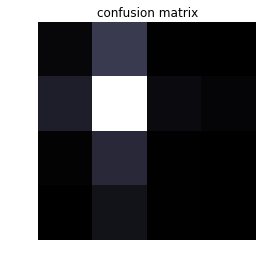

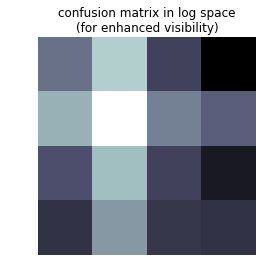

In [371]:
ax = pl.figure().add_subplot(111)
ax.imshow(confusion_matrix(y_test, y_pred), cmap='bone')
ax.set_title("confusion matrix")
ax.axis('off')

ax = pl.figure().add_subplot(111)
ax.imshow(np.log10(confusion_matrix(y_test, y_pred)), cmap='bone')
ax.set_title("confusion matrix in log space\n(for enhanced visibility)")
ax.axis('off');
# imshow(confusion_matrix(y_test, y_pred))

print("confusion matrix\n", len(confusion_matrix(y_test, y_pred)))

### Figure 4. Confusion Matrix . From the above figure, we could find that 'Correctly classified test cases percentage: 56.73%', and the most cases are solved within one day.